# Energy cost comparison

## Initialize

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

import numpy as np


os.chdir('/home/okke/Programming/energy')

### Contract definition
Define contracts to compare & other costs.

In [3]:
# contracts: eur, eur/kWh, eur/kWh
contracts = {'fortum spot':         {'monthly':4.02,   'margin':0.003,  'price':0.0},
             'fortum fixed':        {'monthly':14,     'margin':0.0,    'price':0.0},
             'helen spot':          {'monthly':3.93,   'margin':0.0024, 'price':0.0},
             'helen basic':         {'monthly':3.84,   'margin':0.0,    'price':0.0797},
             'helen green':         {'monthly':3.84,   'margin':0.0,    'price':0.0885},
             'helen wind':          {'monthly':3.84,   'margin':0.0,    'price':0.0844},
             'ekowatti fixed':      {'monthly':11.90,  'margin':0.0,    'price':0.0},
             'oulu spot':           {'monthly':5.0,    'margin':0.0025, 'price':0.0},
             'oulu green':          {'monthly':1.99,   'margin':0.0,    'price':0.0595},
             'oulu farmivoima':     {'monthly':0.0,    'margin':0.0,    'price':0.0744},
             'oulu fixed':          {'monthly':9.9,    'margin':0.0,    'price':0.0},
             'oulu basic':          {'monthly':3.5,    'margin':0.0,    'price':0.0549},
             'loiste spot':         {'monthly':2.99,   'margin':0.0025, 'price':0.0},
             'loiste':              {'monthly':2.97,   'margin':0.0,    'price':0.0529},
             'vihreä spot':         {'monthly':2.95,   'margin':0.0024, 'price':0.0},
             'vattenfall green':    {'monthly':3.5,    'margin':0.0,    'price':0.0581},
             'vattenfall spot':     {'monthly':2.95,   'margin':0.0029, 'price':0.0},
             }

transmission_monthly = 5.51 # eur
transmission = 0.0407 # eur/kWh
tax_energy = 0.0279372 # eur/kWh
tax_pct = 0.24 # %

### Spot price data
Load spot price data from [Nordpool](https://www.nordpoolgroup.com/historical-market-data/) into main DataFrame `df`.

In [4]:
prices = []
for year in [2018, 2019]:
    # read "excel" file (html)
    spot = pd.read_html('elspot-prices_{}_hourly_eur.xls'.format(year), decimal=',')[0]
    
    # remove multilevel
    spot = spot['Elspot Prices in EUR/MWh'][spot.columns[0][1]]
    
    # datetime from date and hour
    spot['Datetime'] = pd.to_datetime(spot['Unnamed: 0_level_2']+' '+spot['Hours'].str.split().str[0]+':00',
                                      dayfirst=True)
    
    # EUR/MWh -> EUR/kWh + tax (ALV)
    spot['FI'] = spot['FI']*0.00001 * (1+tax_pct)
    
    spot.set_index('Datetime', inplace=True)
    prices.append(spot['FI'])

df = pd.concat(prices, sort=True).to_frame()

### Energy consumption data
Load energy consumption data from Helen provided data.

In [5]:
# energy use data
files = ['Käyttö 01.01.2018 - 31.12.2018.xlsx',
         'Käyttö 01.01.2019 - 27.08.2019.xlsx']

uses = []
for f in files:
    use = pd.read_excel(f)
    
    # set missing as nan
    use.loc[use['Tila'] == 'Puuttuva', 'kWh'] = np.nan
    
    # datetime from columns
    use['Datetime'] = pd.to_datetime(dict(year=use['Vuosi'],
                                          month=use['Kuukausi'],
                                          day=use['Päivä'],
                                          hour=use['Tunti'].str.split(':').str[0]))
    
    use.set_index('Datetime', inplace=True)
    uses.append(use['kWh'])

df = df.merge(pd.concat(uses, sort=True), left_index=True, right_index=True, how='inner')

## Results
### Usage summary

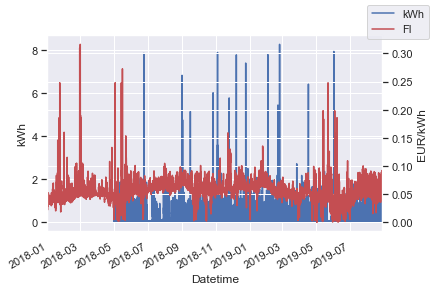

Start: 2018-05-01 00:00:00
End: 2019-08-26 08:00:00
Yearly: 2040.3672480000012 kWh


In [22]:
# plot use vs. price
ax = df.plot(y="kWh", legend=False)
ax2 = ax.twinx()
g = df.plot(y="FI", ax=ax2, legend=False, color="r")
ax2.set(ylabel='EUR/kWh')
ax.set(ylabel='kWh')

ax.figure.legend()
plt.show()

# date interval with usage statistics
print("Start: {}".format(df['kWh'].first_valid_index()))
print("End: {}".format(df['kWh'].last_valid_index()))

# estimate of yearly use
print("Yearly: {} kWh".format(df['kWh'].resample('M').sum().loc['2018-05-01':'2019-07-31'].mean() * 12))

### Monthly costs

In [23]:
costs = pd.DataFrame()

for contract_name, contract in contracts.items():
    
    cost_fun = lambda x:\
        x['kWh']*( x['FI']*(contract['margin']>0) +
        contract['margin'] +
        contract['price'] + 
        transmission + 
        tax_energy )
    
    cost_hourly = df.apply(cost_fun, axis=1)
    cost_monthly = cost_hourly.resample('M').sum() + contract['monthly'] + transmission_monthly
    
    costs[contract_name] = cost_monthly


# limit to available dates
costs = costs.loc['2018-05-01':'2019-08-01']

# sort by overall costs
costs = costs.reindex(columns=sorted(costs.columns, key=lambda c: costs[c].sum()))

In [24]:
#%% latest use costs (comparison to bill)
print('kWh: {}'.format( sum(df['kWh'].loc['2019-05-01':'2019-06-30']) ))
print('costs: {}'.format( sum(costs['helen basic'].loc['2019-05-01':'2019-06-30']) ))

kWh: 292.58123000000256
costs: 62.10068043075628


### Plot monthly cost comparison

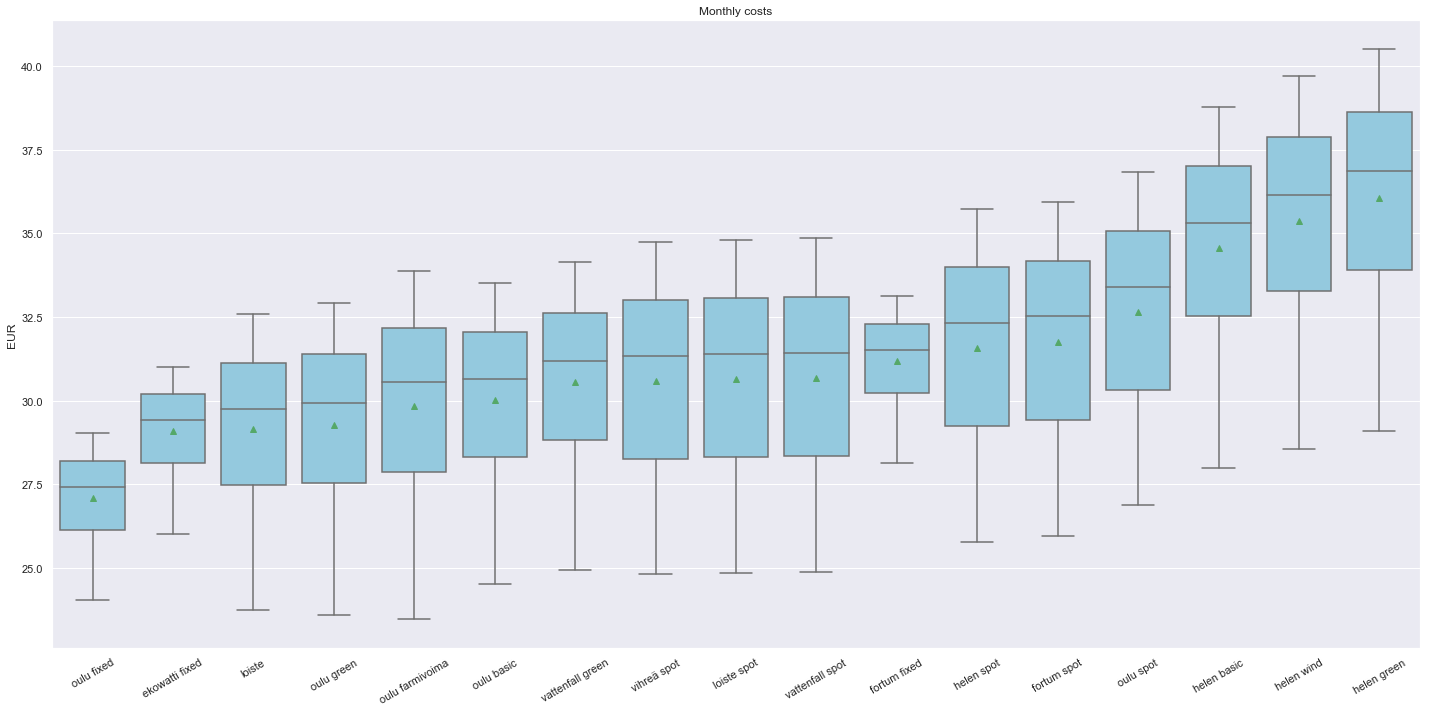

In [25]:
plt.figure(figsize=(20,10))
g = sns.boxplot(data=costs, showmeans=True, color="skyblue")

plt.xticks(rotation=30)
plt.title('Monthly costs')
plt.ylabel('EUR')

plt.tight_layout()